In [71]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor,ExtraTreesRegressor,VotingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso,Ridge


%matplotlib inline

In [18]:
data = pd.read_csv('data/household_power_consumption.txt',delimiter=';')

C:\Users\ymurugan\AppData\Local\Temp\ipykernel_17184\2326647275.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/household_power_consumption.txt',delimiter=';')


In [19]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [20]:
data.shape # Since the size of data is large we will select randomly select 150000 rows
data = data.sample(n=30000)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1332815 to 1313845
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   30000 non-null  object 
 1   Time                   30000 non-null  object 
 2   Global_active_power    30000 non-null  object 
 3   Global_reactive_power  30000 non-null  object 
 4   Voltage                30000 non-null  object 
 5   Global_intensity       30000 non-null  object 
 6   Sub_metering_1         30000 non-null  object 
 7   Sub_metering_2         30000 non-null  object 
 8   Sub_metering_3         29625 non-null  float64
dtypes: float64(1), object(8)
memory usage: 2.3+ MB


In [22]:
data.isnull().sum() # we have null values in the colum sub_metering_3

Date                       0
Time                       0
Global_active_power        0
Global_reactive_power      0
Voltage                    0
Global_intensity           0
Sub_metering_1             0
Sub_metering_2             0
Sub_metering_3           375
dtype: int64

### Attribute Information:

1) date: Date in format dd/mm/yyyy

2) time: time in format hh:mm:ss

3) global_active_power: household global minute-averaged active power (in kilowatt)

4) global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5) voltage: minute-averaged voltage (in volt)

6) global_intensity: household global minute-averaged current intensity (in ampere)

7) sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8) sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9) sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

### Data cleaning/processing

#### We can see that there are many feature which are in object type which should be coverted to float or int type

In [23]:
data[["day", "month", "year"]] = data["Date"].str.split("/", expand = True)
data['Time'] = pd.to_timedelta(data['Time'])

In [24]:
data['TimeInMinute'] = data['Time'].dt.total_seconds().div(60).astype(int)+1
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute
1332815,29/6/2009,0 days 06:59:00,0.456,0.340,239.920,2.400,0.000,1.000,0.0,29,6,2009,420
498700,28/11/2007,0 days 01:04:00,0.472,0.234,243.340,2.200,0.000,2.000,0.0,28,11,2007,65
665921,23/3/2008,0 days 04:05:00,0.320,0.064,246.980,1.600,0.000,0.000,0.0,23,3,2008,246
1409218,21/8/2009,0 days 08:22:00,2.026,0.200,236.710,8.600,1.000,0.000,29.0,21,8,2009,503
1610407,8/1/2010,0 days 01:31:00,0.424,0.236,246.460,2.000,0.000,0.000,0.0,8,1,2010,92


In [25]:
numericColums = [col for col in data.columns if col not in {'Date','Time'}]
data[numericColums] = data[numericColums].apply(pd.to_numeric,errors='coerce')

In [26]:
data.info() # There are some significunt amount of null values which are need to be handled

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1332815 to 1313845
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   Date                   30000 non-null  object         
 1   Time                   30000 non-null  timedelta64[ns]
 2   Global_active_power    29625 non-null  float64        
 3   Global_reactive_power  29625 non-null  float64        
 4   Voltage                29625 non-null  float64        
 5   Global_intensity       29625 non-null  float64        
 6   Sub_metering_1         29625 non-null  float64        
 7   Sub_metering_2         29625 non-null  float64        
 8   Sub_metering_3         29625 non-null  float64        
 9   day                    30000 non-null  int64          
 10  month                  30000 non-null  int64          
 11  year                   30000 non-null  int64          
 12  TimeInMinute           30000 non-null 

In [27]:
data = data.drop(['Time','Date'],axis = 1)

In [28]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute
1332815,0.456,0.340,239.92,2.4,0.0,1.0,0.0,29,6,2009,420
498700,0.472,0.234,243.34,2.2,0.0,2.0,0.0,28,11,2007,65
665921,0.320,0.064,246.98,1.6,0.0,0.0,0.0,23,3,2008,246
1409218,2.026,0.200,236.71,8.6,1.0,0.0,29.0,21,8,2009,503
1610407,0.424,0.236,246.46,2.0,0.0,0.0,0.0,8,1,2010,92


### EDA

### Univariate analysis

In [29]:
# define numerical & categorical columns
numeric_features = [feature for feature in data.columns if data[feature].dtype != 'O']
categorical_features = [feature for feature in data.columns if data[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 11 numerical features : ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'day', 'month', 'year', 'TimeInMinute']

We have 0 categorical features : []


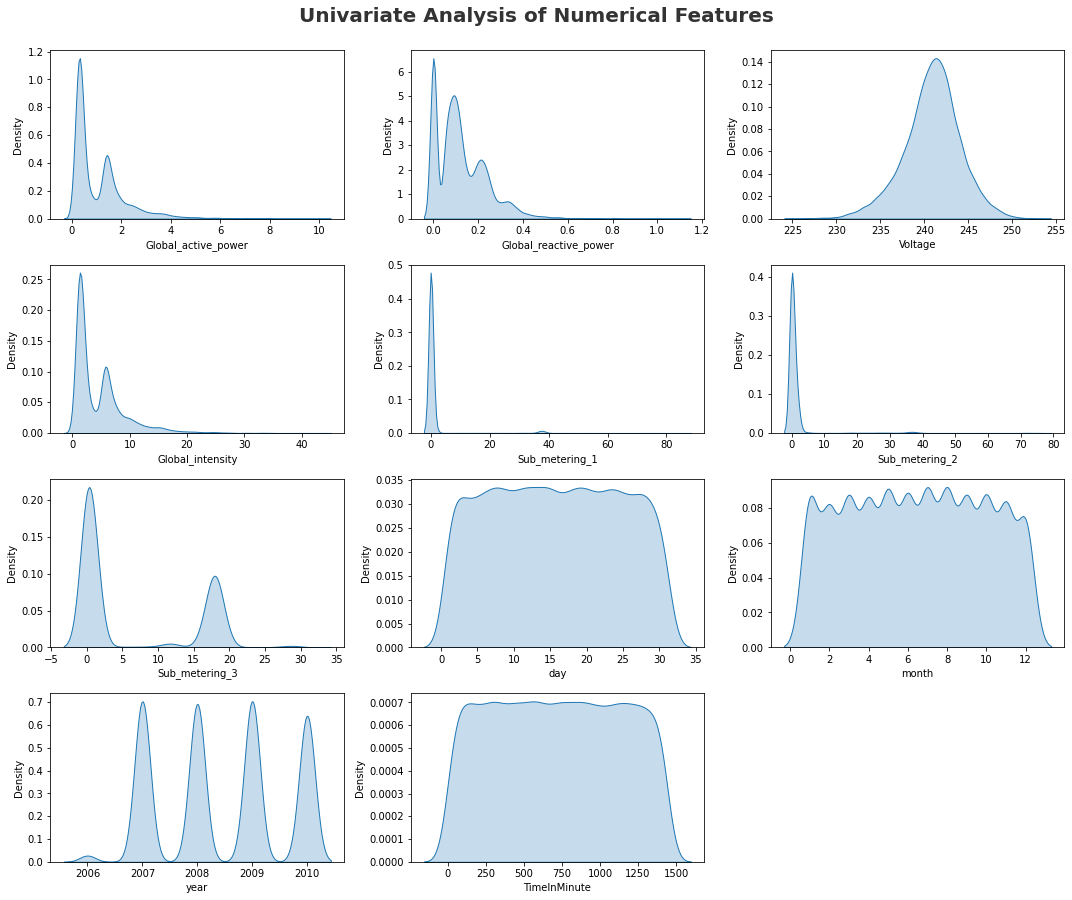

In [30]:
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_features)):
    plt.subplot(5, 3, i+1)
    sns.kdeplot(x=data[numeric_features[i]],fill=True,palette="crest")
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

#### Observations
1) We can neglate the distribution for year, timeinminute, day and month

2) Sub_metering 1,2 and 3 seems to right skewed which says people usally consume more electricty during morning period.
   So we can combine these three features and make into one during the feature engineering process

3) Volatage is normally distributed

Num of continues features : ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'day', 'month', 'TimeInMinute']


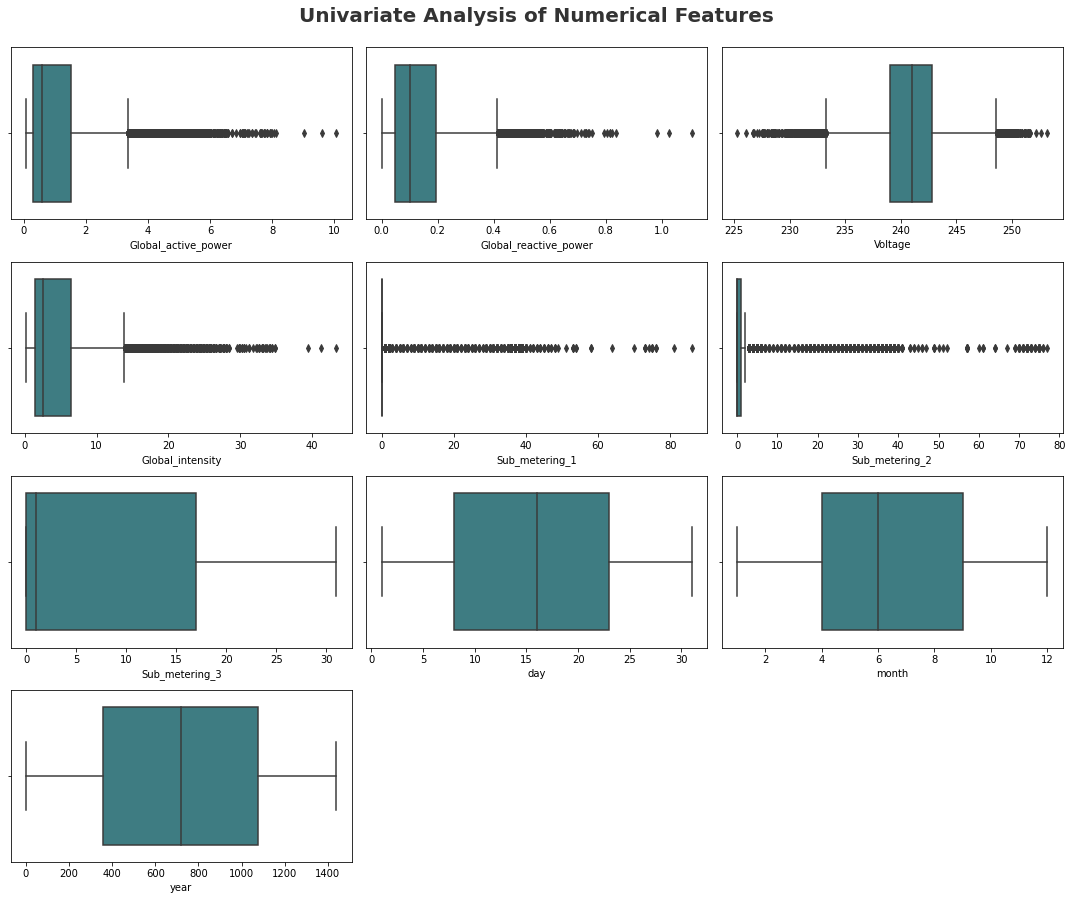

In [31]:
continues_features=[feature for feature in numeric_features if len(data[feature].unique())>=10]
print('Num of continues features :',continues_features)

plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)


for i in range(0, len(continues_features)):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=data[continues_features[i]],palette="crest")
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

### Bivariate analysis

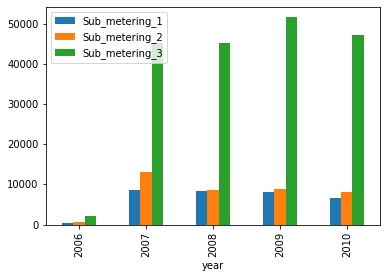

In [32]:
groupByYear = data.groupby(['year']).sum()
groupByYear[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].plot(kind = 'bar')
groupByYear['total_sub_metering'] = groupByYear['Sub_metering_1'] + groupByYear['Sub_metering_2'] + groupByYear['Sub_metering_1']

In [33]:
groupByYear 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,TimeInMinute,total_sub_metering
year,,,,,,,,,,,
2006,563.854,37.356,71707.01,2390.2,453.0,724.0,2206.0,7031,3564,228493,1630.0
2007,8513.210,870.942,1812508.32,36300.6,8657.0,13100.0,45081.0,119951,50013,5397200,30414.0
2008,7998.938,868.686,1805470.46,33953.4,8420.0,8700.0,45078.0,118865,48589,5416141,25540.0
2009,8082.450,1004.144,1833380.15,34149.8,8198.0,8876.0,51541.0,119577,50247,5457384,25272.0
2010,7057.848,875.310,1612174.94,29811.2,6541.0,8185.0,47172.0,107211,40894,5016926,21267.0


#### we can see that the maximum submeter consumption has happened on year 2007

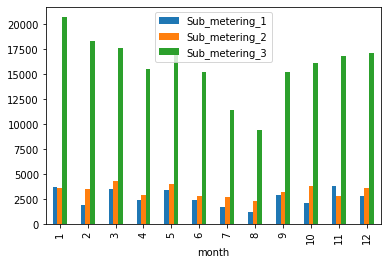

In [34]:
groupByMonth = data.groupby(['month']).sum()
groupByMonth[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].plot(kind = 'bar')
groupByMonth['total_sub_metering'] = groupByMonth['Sub_metering_1'] + groupByMonth['Sub_metering_2'] + groupByMonth['Sub_metering_1']

In [35]:
groupByMonth

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,year,TimeInMinute,total_sub_metering
month,,,,,,,,,,,
1,3797.950,285.310,627556.61,15935.6,3755.0,3584.0,20737.0,41248,5300475,1887347,11094.0
2,3056.120,233.626,560049.09,12806.6,1955.0,3469.0,18318.0,33477,4657756,1714527,7379.0
3,3152.220,277.608,602381.87,13250.8,3484.0,4350.0,17637.0,41027,5063421,1837270,11318.0
4,2454.428,294.754,579524.46,10372.4,2444.0,2897.0,15560.0,37789,4932929,1752786,7785.0
5,2727.230,333.640,625974.85,11669.2,3421.0,3966.0,17472.0,41512,5260260,1892108,10808.0
6,2150.062,356.428,594113.21,9288.4,2458.0,2832.0,15190.0,39733,5069435,1803935,7748.0
7,1847.036,395.706,631771.45,8080.8,1753.0,2722.0,11469.0,42400,5292416,1840882,6228.0
8,1410.692,349.360,603875.25,6198.4,1226.0,2280.0,9369.0,41989,5302491,1869228,4732.0
9,2402.356,324.974,582638.82,10261.6,2929.0,3241.0,15182.0,38414,5009223,1794337,9099.0


#### submeter consumption is high during the 1st half of the year. May be thats the summer time for them

## Multivariate analysis

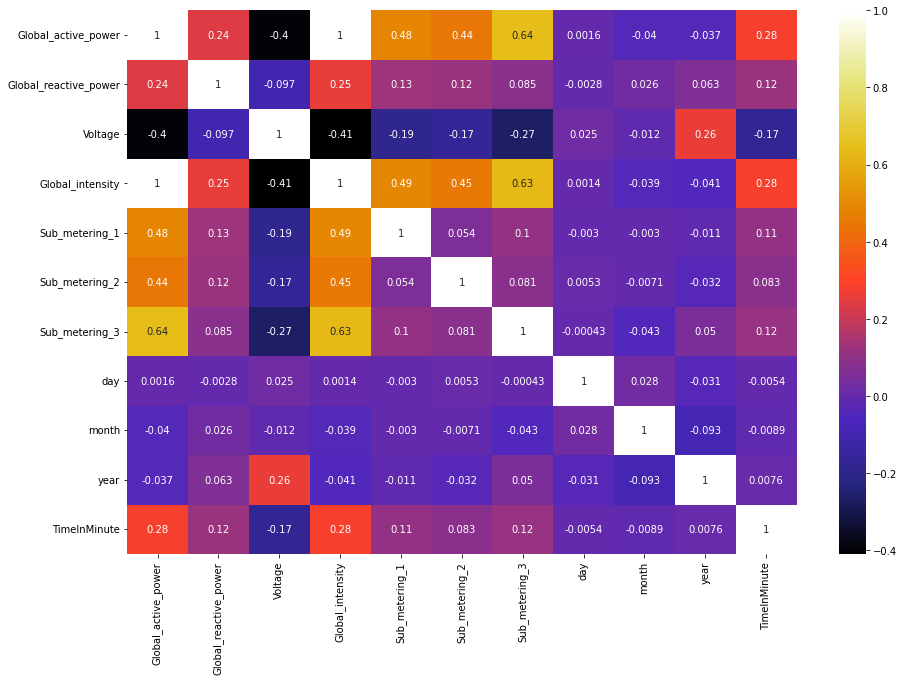

In [36]:
plt.figure(figsize = (15,10))
sns.heatmap(data.corr(), cmap="CMRmap", annot=True)
plt.show()

### Feature Engineering
#### Lets perform some feature engineering and analysis the corillation after that

In [37]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute
1332815,0.456,0.340,239.92,2.4,0.0,1.0,0.0,29,6,2009,420
498700,0.472,0.234,243.34,2.2,0.0,2.0,0.0,28,11,2007,65
665921,0.320,0.064,246.98,1.6,0.0,0.0,0.0,23,3,2008,246
1409218,2.026,0.200,236.71,8.6,1.0,0.0,29.0,21,8,2009,503
1610407,0.424,0.236,246.46,2.0,0.0,0.0,0.0,8,1,2010,92


In [38]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute
count,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,30000.000000,30000.000000,30000.000000,30000.00000
mean,1.087470,0.123424,240.852013,4.611146,1.089249,1.336203,6.449890,15.754500,6.443567,2008.442933,717.20480
std,1.062191,0.111349,3.231395,4.465773,6.104904,6.015035,8.424339,8.777646,3.409008,1.130245,414.26834
min,0.078000,0.000000,225.280000,0.200000,0.000000,0.000000,0.000000,1.000000,1.000000,2006.000000,1.00000
25%,0.308000,0.048000,239.020000,1.400000,0.000000,0.000000,0.000000,8.000000,4.000000,2007.000000,358.00000
50%,0.586000,0.100000,241.040000,2.600000,0.000000,0.000000,1.000000,16.000000,6.000000,2008.000000,717.00000
75%,1.526000,0.194000,242.860000,6.400000,0.000000,1.000000,17.000000,23.000000,9.000000,2009.000000,1077.00000
max,10.064000,1.108000,253.190000,43.400000,86.000000,77.000000,31.000000,31.000000,12.000000,2010.000000,1440.00000


In [39]:
#replacing the null values with median becuase there are lot of outliers we found
Sub_metering_1_median=data['Sub_metering_1'].median()
Sub_metering_2_median=data['Sub_metering_2'].median()
Sub_metering_3_median=data['Sub_metering_3'].median()
Global_active_power_median=data['Global_active_power'].median()
Global_reactive_power_median=data['Global_reactive_power'].median()
Voltage_median=data['Voltage'].median()
Global_intensity_median=data['Global_intensity'].median()

data['Sub_metering_1'].fillna(value=Sub_metering_1_median, inplace=True)
data['Sub_metering_2'].fillna(value=Sub_metering_2_median, inplace=True)
data['Sub_metering_3'].fillna(value=Sub_metering_3_median, inplace=True)
data['Global_active_power'].fillna(value=Global_active_power_median, inplace=True)
data['Global_reactive_power'].fillna(value=Global_reactive_power_median, inplace=True)
data['Voltage'].fillna(value=Voltage_median, inplace=True)
data['Global_intensity'].fillna(value=Global_intensity_median, inplace=True)


In [40]:
data.info() # We have handled handled missing values with median

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1332815 to 1313845
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    30000 non-null  float64
 1   Global_reactive_power  30000 non-null  float64
 2   Voltage                30000 non-null  float64
 3   Global_intensity       30000 non-null  float64
 4   Sub_metering_1         30000 non-null  float64
 5   Sub_metering_2         30000 non-null  float64
 6   Sub_metering_3         30000 non-null  float64
 7   day                    30000 non-null  int64  
 8   month                  30000 non-null  int64  
 9   year                   30000 non-null  int64  
 10  TimeInMinute           30000 non-null  int32  
dtypes: float64(7), int32(1), int64(3)
memory usage: 3.6 MB


In [41]:
data['Sub_metering'] = data['Sub_metering_1'] + data['Sub_metering_2'] + data['Sub_metering_3']

In [42]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute,Sub_metering
1332815,0.456,0.340,239.92,2.4,0.0,1.0,0.0,29,6,2009,420,1.0
498700,0.472,0.234,243.34,2.2,0.0,2.0,0.0,28,11,2007,65,2.0
665921,0.320,0.064,246.98,1.6,0.0,0.0,0.0,23,3,2008,246,0.0
1409218,2.026,0.200,236.71,8.6,1.0,0.0,29.0,21,8,2009,503,30.0
1610407,0.424,0.236,246.46,2.0,0.0,0.0,0.0,8,1,2010,92,0.0


In [43]:
data.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute,Sub_metering
Global_active_power,1.000000,0.236185,-0.398174,0.998885,0.484283,0.445441,0.639311,-0.001687,-0.039373,-0.041913,0.276668,0.851660
Global_reactive_power,0.236185,1.000000,-0.097150,0.254408,0.126357,0.123299,0.086321,-0.004270,0.026137,0.060073,0.123173,0.173041
Voltage,-0.398174,-0.097150,1.000000,-0.409518,-0.191463,-0.172482,-0.267443,0.025342,-0.012246,0.256071,-0.172113,-0.344597
Global_intensity,0.998885,0.254408,-0.409518,1.000000,0.489168,0.451156,0.627128,-0.001763,-0.037968,-0.045684,0.276792,0.848675
Sub_metering_1,0.484283,0.126357,-0.191463,0.489168,1.000000,0.054790,0.103875,-0.004180,-0.002814,-0.012521,0.105517,0.564308
Sub_metering_2,0.445441,0.123299,-0.172482,0.451156,0.054790,1.000000,0.082445,0.003743,-0.006775,-0.033717,0.082481,0.543833
Sub_metering_3,0.639311,0.086321,-0.267443,0.627128,0.103875,0.082445,1.000000,-0.004911,-0.041778,0.042574,0.114498,0.738970
day,-0.001687,-0.004270,0.025342,-0.001763,-0.004180,0.003743,-0.004911,1.000000,0.027729,-0.031449,-0.005380,-0.003432
month,-0.039373,0.026137,-0.012246,-0.037968,-0.002814,-0.006775,-0.041778,0.027729,1.000000,-0.092815,-0.008858,-0.031701
year,-0.041913,0.060073,0.256071,-0.045684,-0.012521,-0.033717,0.042574,-0.031449,-0.092815,1.000000,0.007606,0.006194


#### Observation
1) We see same level of corrillation for Global_active_power and Global_reactive_power with the target variable so any one can removed

2) We see no corrilation with day year and month with target variable (sub_metering) so we can drop it

In [44]:
data = data.drop(['Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3','day','month','year'],axis=1)

In [45]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,TimeInMinute,Sub_metering
1332815,0.456,0.340,239.92,420,1.0
498700,0.472,0.234,243.34,65,2.0
665921,0.320,0.064,246.98,246,0.0
1409218,2.026,0.200,236.71,503,30.0
1610407,0.424,0.236,246.46,92,0.0


In [46]:
# algo to be implemented
# 1) bagging regressor
# 2) extra tree regressor
# 3) voting classifier and regressor 
# 4) random forest regressor

### Train and Test split

In [48]:
data_copy = data.copy()
X = data_copy.drop('Sub_metering',axis=1)
y= data_copy['Sub_metering']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=10)

In [49]:
X.shape

(30000, 4)

In [50]:
y.shape

(30000,)

### Bagging regression

In [53]:
bagging_regressor = BaggingRegressor(n_estimators=10, random_state=0).fit(X_train, y_train)

In [59]:
y_predict_bagging=bagging_regressor.predict(X_test)

In [62]:
bagging_r2_score = r2_score(y_test,y_predict_bagging)
bagging_r2_adj_score = 1 - (1-bagging_reg_score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [63]:
print(f"r2 => {bagging_r2_score} || adjusted r2 => {bagging_r2_adj_score}")

r2 => 0.8201460557013124 || adjusted r2 => 0.8200733507213028


### Extratree regressor

In [66]:
extratree_regressor = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

In [67]:
y_predict_extratree=extratree_regressor.predict(X_test)

In [68]:
extratree_r2_score = r2_score(y_test,y_predict_extratree)
extratree_r2_adj_score = 1 - (1-extratree_r2_score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [69]:
print(f"r2 => {extratree_r2_score} || adjusted r2 => {extratree_r2_adj_score}")

r2 => 0.8368313335729178 || adjusted r2 => 0.8367653735258528


### Voting regressor

In [72]:
# Since we will be using multiple models here some of them will be needing standardization

In [73]:
scaler=StandardScaler()
X_train_trans=scaler.fit_transform(X_train)
X_test_trans=scaler.transform(X_test)

In [74]:
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = Ridge(alpha=1.0)
r4 = Lasso(alpha=0.1)

In [77]:
voting_regressor = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3), ('r4', r4)])

In [81]:
voting_regressor.fit(X_train_trans, y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rf',
                             RandomForestRegressor(n_estimators=10,
                                                   random_state=1)),
                            ('r3', Ridge()), ('r4', Lasso(alpha=0.1))])

In [83]:
y_predict_voting=voting_regressor.predict(X_test_trans)

In [84]:
voting_r2_score = r2_score(y_test,y_predict_voting)
voting_r2_adj_score = 1 - (1-voting_r2_score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [85]:
print(f"r2 => {voting_r2_score} || adjusted r2 => {voting_r2_adj_score}")

r2 => 0.7893038928050371 || adjusted r2 => 0.7892187200482125
